In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../src/utils")
from utils import SimpleGraphVoltDatasetLoader_Lazy
from models import GNN_GCNLSTM_ea
import torch
import torch.nn.functional as F
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric import seed_everything

In [2]:
trafo_id = "T1330"
epochs = 1
num_timesteps_in = 1
num_timesteps_out = 4
test_ratio_vs_eval_ratio = 0.5
learning_rate = 0.1
device_str = 'cpu'
hidden = 64
manual_seed = 42

In [3]:
print("Loading data...")
loader = SimpleGraphVoltDatasetLoader_Lazy(trafo_id, num_timesteps_in, num_timesteps_out)
print(" done")
loader_data_index = loader.snapshot_index

train_dataset, test_eval_dataset = loader.temporal_signal_split_lazy_cut(loader_data_index)
eval_dataset, test_dataset = loader.temporal_signal_split_lazy(test_eval_dataset, train_ratio=test_ratio_vs_eval_ratio)


Loading data...
c:\Users\tomot\OneDrive\Namizje\mlg\Project\GraphVolt
c:\Users\tomot\OneDrive\Namizje\mlg\Project\GraphVolt\data\networks_data_raw
Voltage index: 5
 done


In [4]:
from models import avgModel

In [5]:
def eval(model, loader, test_dataset, loss_fn, std, mean):
    preds = []
    ys = []
    with torch.no_grad():
        model.eval()
        loss_all = 0
        loss_elementwise = 0
        
        for snapshot_j in tqdm(test_dataset, desc="Evaluating"):
            snapshot = loader.get_snapshot(snapshot_j)
            snapshot = snapshot
            
            out= model(snapshot.x, snapshot.edge_index)

            loss_all += loss_fn()(out, snapshot.y).cpu().numpy()
            loss_elementwise += loss_fn(reduction="none")(out, snapshot.y).cpu().numpy()

            ys.append(snapshot.y.cpu().numpy()*std+mean)
            preds.append(out.cpu().numpy()*std+mean)
            
        loss_all *= std/len(test_dataset)
        loss_elementwise *= std/len(test_dataset)

        ys = np.stack(ys, axis=-1)
        preds = np.stack(preds, axis=-1)
    return loss_all, loss_elementwise, preds, ys

In [6]:
is_pmo = np.array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [7]:
model = avgModel(num_timesteps_out, loader.voltage_index)
loss_fn = torch.nn.L1Loss
std = loader.mean_and_std["measurements"][1]["voltage"]
mean = loader.mean_and_std["measurements"][0]["voltage"]

In [8]:
loss_test, loss_test_elementwise, preds, ys = eval(model, loader, test_dataset, loss_fn, std, mean)
loss_test_timewise = loss_test_elementwise.mean(axis=0)
print("Loss all: {:.7f}".format(loss_test))
print("Loss elementwise: {}".format(loss_test_elementwise))

Evaluating: 100%|██████████| 1440/1440 [00:00<00:00, 2676.00it/s]

Loss all: 0.8312117
Loss elementwise: [[0.46027318 0.66550475 0.77294004 0.83711016]
 [0.5017598  0.731133   0.8554375  0.92861557]
 [0.5017598  0.731133   0.8554375  0.92861557]
 [0.5017598  0.731133   0.8554375  0.92861557]
 [0.5017598  0.731133   0.8554375  0.92861557]
 [0.5017598  0.731133   0.8554375  0.92861557]
 [0.5017598  0.731133   0.8554375  0.92861557]
 [0.5017598  0.731133   0.8554375  0.92861557]
 [0.5060181  0.73081005 0.86247635 0.9388651 ]
 [0.54543513 0.77886957 0.8997725  0.9713915 ]
 [0.5371636  0.7698027  0.8881826  0.96105236]
 [0.5376608  0.77055484 0.8895482  0.9621874 ]
 [0.4739829  0.6744526  0.7826811  0.8470589 ]
 [0.5376613  0.7720131  0.8910416  0.9638877 ]
 [0.47299156 0.67730874 0.7899826  0.86730784]
 [0.5409369  0.7770482  0.8975109  0.96885324]
 [0.5392928  0.77267253 0.88915414 0.9628109 ]
 [0.71925294 0.9114057  1.0413308  1.0971518 ]
 [0.46547464 0.67758065 0.79129606 0.8614335 ]
 [0.5017598  0.731133   0.8554375  0.92861557]
 [0.4667474  0.682048 

In [9]:
import matplotlib.pyplot as plt

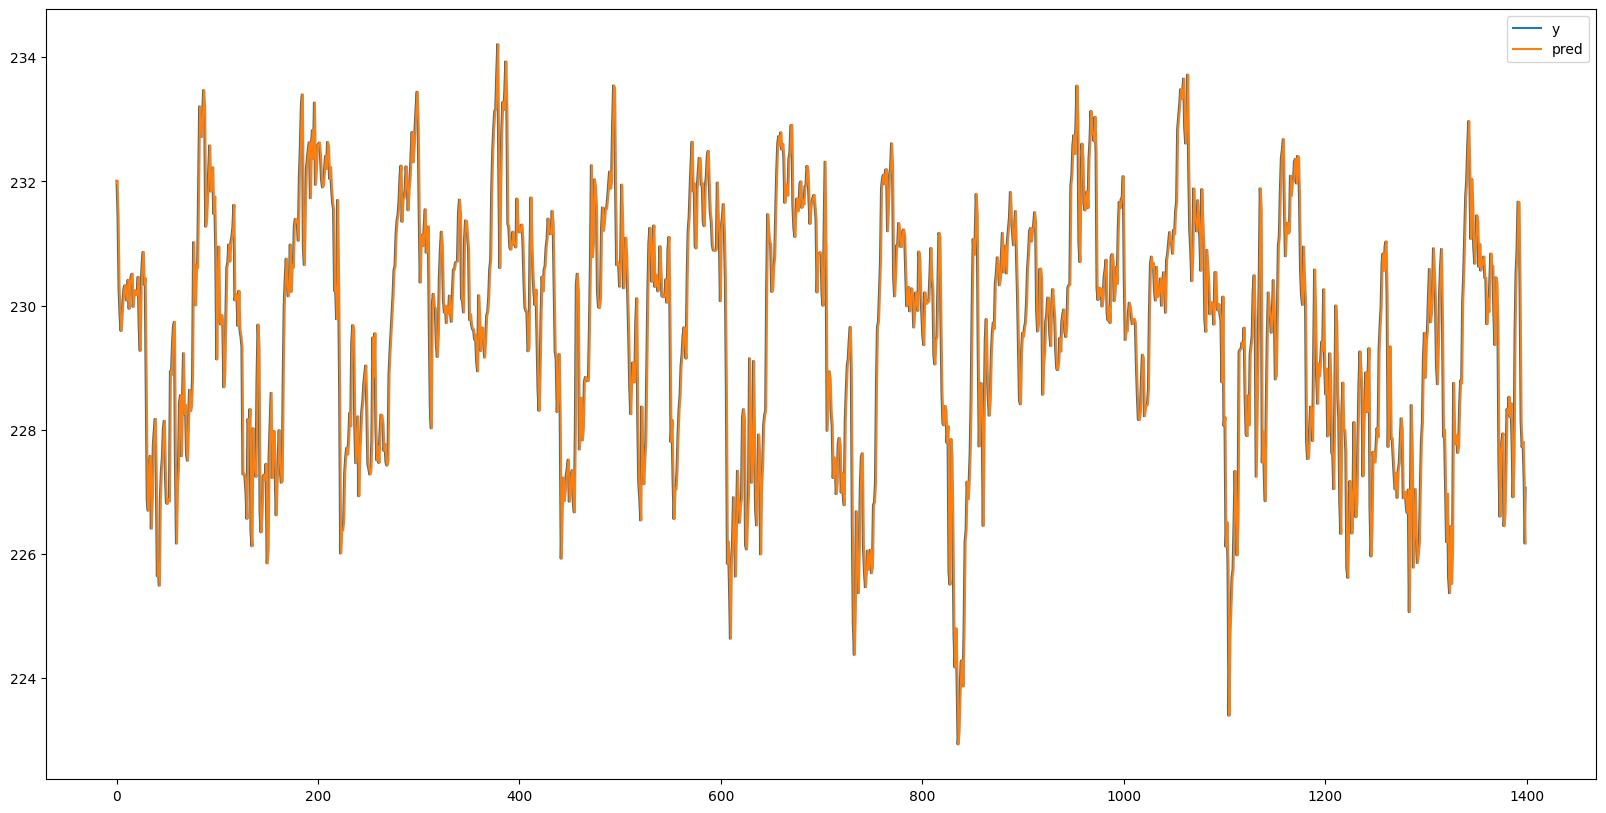

In [10]:
node = 50
pred_ind = 0

start = 0
len_measurements = 1400

plt.figure(figsize=(20,10))
plt.plot(ys[node,pred_ind,start:start+len_measurements], label="y")
plt.plot(preds[node,pred_ind,start:start+len_measurements], label="pred")
plt.legend()

In [11]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../src/utils")
from utils import SimpleGraphVoltDatasetLoader, read_and_prepare_data, read_raw_network_data
from torch_geometric_temporal.signal import temporal_signal_split
import torch

In [12]:
trafo_id = "T1330"

In [13]:
dfs = read_and_prepare_data(trafo_id)

c:\Users\tomot\OneDrive\Namizje\mlg\Project\GraphVolt
c:\Users\tomot\OneDrive\Namizje\mlg\Project\GraphVolt\data\networks_data_raw


In [14]:
dfs[0]["edges_static_data"].head()

,from_node_id,to_node_id,length_km,r_ohm_per_km,x_ohm_per_km,max_i_ka,d_mm2
0,94,110,-0.167420,-0.562549,-0.027228,0.255013,0.211420
1,100,110,-0.427878,-0.562549,-0.027228,0.255013,0.211420
2,103,110,-0.413408,-0.054951,0.250450,-0.494527,-0.506509
3,103,104,-0.456818,-0.468438,0.250450,0.027474,-0.506509
4,6,7,0.367968,-0.562549,-0.027228,0.255013,0.211420


In [15]:
dfs[0]["measurements"].head()

,node_id,power_production,power_consumption,PMO,TR,junction,date_time,voltage,temperature_2m,snow_depth,...,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,minute_sin,minute_cos
0,0,-0.669711,-0.211164,0,1,0,2021-06-01 00:00:00,0.871501,-0.087913,-0.373525,...,0.0,1.0,0.439054,0.898461,0.0,1.0,0.000000,1.000000,0.000000,1.000000
1,0,-0.669711,-0.211164,0,1,0,2021-06-01 00:15:00,0.837781,-0.099327,-0.373525,...,0.0,1.0,0.439054,0.898461,0.0,1.0,0.000000,1.000000,0.327195,0.944957
2,0,-0.669711,-0.211164,0,1,0,2021-06-01 00:30:00,0.977922,-0.110742,-0.373525,...,0.0,1.0,0.439054,0.898461,0.0,1.0,0.000000,1.000000,0.618370,0.785887
3,0,-0.669711,-0.211164,0,1,0,2021-06-01 00:45:00,0.581175,-0.122156,-0.373525,...,0.0,1.0,0.439054,0.898461,0.0,1.0,0.000000,1.000000,0.841471,0.540302
4,0,-0.669711,-0.211164,0,1,0,2021-06-01 01:00:00,0.501061,-0.133570,-0.373525,...,0.0,1.0,0.439054,0.898461,0.0,1.0,0.043465,0.999055,0.000000,1.000000


In [16]:
dfs_raw = read_raw_network_data(trafo_id)

c:\Users\tomot\OneDrive\Namizje\mlg\Project\GraphVolt
c:\Users\tomot\OneDrive\Namizje\mlg\Project\GraphVolt\data\networks_data_raw


In [17]:
dfs_raw = dfs_raw[0]

In [18]:
print(f"Št. smm: {len(dfs_raw['nodes_static_data'].smm.unique())-1}") #-1 for nan
print(f"Št. bus: {len(dfs_raw['nodes_static_data'].bus.unique())}")
print(f"št. junction: {dfs_raw['nodes_static_data'].aclass_id.value_counts()['junction']}")
print(f"št. transformer: {dfs_raw['nodes_static_data'].aclass_id.value_counts()['TR']}")
print(f"št. PMO: {dfs_raw['nodes_static_data'].aclass_id.value_counts()['PMO']}")
print(f"št. RO: {dfs_raw['nodes_static_data'].aclass_id.value_counts()['RO']}")
print(len(dfs_raw['nodes_static_data']))
print(dfs_raw['nodes_static_data'].aclass_id.unique())

Št. smm: 139
Št. bus: 113
št. junction: 5
št. transformer: 1
št. PMO: 142
št. RO: 7
155
['junction' 'PMO' 'TR' 'RO']


In [19]:
#display head(3) of all dataframes in dfs_raw and dfs[0]
for name, df in dfs_raw.items():
    print(name)
    pd.options.display.max_columns = None
    display(df.head(3))
for name, df in dfs[0].items():
    print(name)
    pd.options.display.max_columns = None
    display(df.head(3))

edges_static_data


,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,max_i_ka,type,d_mm2,coords,coords_transformed
0,55579,96697,0.055,0.533,0.079,0.176,cs,70.0,"[[530374.6612999998, 153999.8621999994], [5303...","[[21.486049387812564, 49.254584020619056], [21..."
1,55593,96697,0.037,0.533,0.079,0.176,cs,70.0,"[[530337.4517000001, 154015.33029999956], [530...","[[21.485565488389135, 49.2547210147785], [21.4..."
2,55615,96697,0.038,1.040,0.081,0.120,cs,35.0,"[[530337.4517000001, 154015.33029999956], [530...","[[21.485565488389135, 49.2547210147785], [21.4..."


nodes_static_data


,aclass_id,bus,smm,prikljucna_moc_odjem,prikljucna_moc_oddaja,x_y,lon_lat
0,junction,97327,NaN,NaN,NaN,"(530588.0843000002, 153821.05189999938)","(21.48883237280564, 49.25298769476685)"
1,PMO,55363,110471.0,35.0,0.0,"(530715.1489000004, 154094.69480000064)","(21.490457517273, 49.25545698477883)"
2,PMO,55364,91558.0,17.0,14.0,"(530714.4113999996, 153845.96270000003)","(21.49046867801605, 49.25321912788421)"


SMM_measurements


,date_time,SMM,trafo_station_id,active_energy,active_power,reactive_energy,reactive_power,trafo_id,current,voltage,temperature_2m,snow_depth,cloud_cover,is_day,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance
0,2021-06-01 00:00:00,2671.0,2063.0,1.144,4.576,0.0,0.0,440.0,NaN,233.766667,13.037499,0.0,20.1,0.0,0.0,0.0,0.0,0.0
1,2021-06-01 00:15:00,2671.0,2063.0,1.223,4.892,0.0,0.0,440.0,NaN,233.866667,12.950000,0.0,20.1,0.0,0.0,0.0,0.0,0.0
2,2021-06-01 00:30:00,2671.0,2063.0,1.254,5.016,0.0,0.0,440.0,NaN,234.016667,12.862499,0.0,20.1,0.0,0.0,0.0,0.0,0.0


TP_measurements


,date_time,trafo_id,trafo_station_id,active_power,reactive_power,voltage,current,temperature_2m,snow_depth,cloud_cover,is_day,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance
0,2021-06-01 00:00:00,440.0,2063.0,152100.000000,23600.000000,234.257778,219.144444,10.065499,0.0,28.50,0.0,0.0,0.0,0.0,0.0
1,2021-06-01 00:15:00,440.0,2063.0,129466.666667,19766.666667,234.101111,186.588889,9.965500,0.0,26.25,0.0,0.0,0.0,0.0,0.0
2,2021-06-01 00:30:00,440.0,2063.0,126266.666667,20233.333333,234.752222,181.800000,9.865500,0.0,24.00,0.0,0.0,0.0,0.0,0.0


edges_static_data


,from_node_id,to_node_id,length_km,r_ohm_per_km,x_ohm_per_km,max_i_ka,d_mm2
0,94,110,-0.167420,-0.562549,-0.027228,0.255013,0.211420
1,100,110,-0.427878,-0.562549,-0.027228,0.255013,0.211420
2,103,110,-0.413408,-0.054951,0.250450,-0.494527,-0.506509


measurements


,node_id,power_production,power_consumption,PMO,TR,junction,date_time,voltage,temperature_2m,snow_depth,cloud_cover,is_day,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,active_power,reactive_power,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,minute_sin,minute_cos
0,0,-0.669711,-0.211164,0,1,0,2021-06-01 00:00:00,0.871501,-0.087913,-0.373525,-0.575472,-0.993346,-0.673222,-0.563245,-0.758562,-0.682145,7.244788,5.311676,0.0,1.0,0.439054,0.898461,0.0,1.0,0.0,1.0,0.000000,1.000000
1,0,-0.669711,-0.211164,0,1,0,2021-06-01 00:15:00,0.837781,-0.099327,-0.373525,-0.635970,-0.993346,-0.673222,-0.563245,-0.758562,-0.682145,6.153428,4.436051,0.0,1.0,0.439054,0.898461,0.0,1.0,0.0,1.0,0.327195,0.944957
2,0,-0.669711,-0.211164,0,1,0,2021-06-01 00:30:00,0.977922,-0.110742,-0.373525,-0.696469,-0.993346,-0.673222,-0.563245,-0.758562,-0.682145,5.999126,4.542649,0.0,1.0,0.439054,0.898461,0.0,1.0,0.0,1.0,0.618370,0.785887


In [20]:
dfs, mean_and_std = dfs

In [21]:
dfs

{'edges_static_data':      from_node_id  to_node_id  length_km  r_ohm_per_km  x_ohm_per_km  \
 0              94         110  -0.167420     -0.562549     -0.027228   
 1             100         110  -0.427878     -0.562549     -0.027228   
 2             103         110  -0.413408     -0.054951      0.250450   
 3             103         104  -0.456818     -0.468438      0.250450   
 4               6           7   0.367968     -0.562549     -0.027228   
 ..            ...         ...        ...           ...           ...   
 109            29           0   2.466107     -0.943999     -0.582581   
 110            19           0   2.364817     -0.847885     -0.443742   
 111            25           0   1.742611     -0.562549     -0.027228   
 112            12           0  -0.876446     -0.975035     -0.443743   
 113            12           0  -0.876446     -0.975035     -0.443743   
 
      max_i_ka     d_mm2  
 0    0.255013  0.211420  
 1    0.255013  0.211420  
 2   -0.494527 -0.50

In [22]:
df_m = dfs['measurements']
df_e = dfs['edges_static_data']

In [23]:
df_m.head()

,node_id,power_production,power_consumption,PMO,TR,junction,date_time,voltage,temperature_2m,snow_depth,cloud_cover,is_day,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,active_power,reactive_power,year_sin,year_cos,month_sin,month_cos,day_sin,day_cos,hour_sin,hour_cos,minute_sin,minute_cos
0,0,-0.669711,-0.211164,0,1,0,2021-06-01 00:00:00,0.871501,-0.087913,-0.373525,-0.575472,-0.993346,-0.673222,-0.563245,-0.758562,-0.682145,7.244788,5.311676,0.0,1.0,0.439054,0.898461,0.0,1.0,0.000000,1.000000,0.000000,1.000000
1,0,-0.669711,-0.211164,0,1,0,2021-06-01 00:15:00,0.837781,-0.099327,-0.373525,-0.635970,-0.993346,-0.673222,-0.563245,-0.758562,-0.682145,6.153428,4.436051,0.0,1.0,0.439054,0.898461,0.0,1.0,0.000000,1.000000,0.327195,0.944957
2,0,-0.669711,-0.211164,0,1,0,2021-06-01 00:30:00,0.977922,-0.110742,-0.373525,-0.696469,-0.993346,-0.673222,-0.563245,-0.758562,-0.682145,5.999126,4.542649,0.0,1.0,0.439054,0.898461,0.0,1.0,0.000000,1.000000,0.618370,0.785887
3,0,-0.669711,-0.211164,0,1,0,2021-06-01 00:45:00,0.581175,-0.122156,-0.373525,-0.756967,-0.993346,-0.673222,-0.563245,-0.758562,-0.682145,5.541044,3.210176,0.0,1.0,0.439054,0.898461,0.0,1.0,0.000000,1.000000,0.841471,0.540302
4,0,-0.669711,-0.211164,0,1,0,2021-06-01 01:00:00,0.501061,-0.133570,-0.373525,-0.817466,-0.993346,-0.673222,-0.563245,-0.758562,-0.682145,5.786962,3.941133,0.0,1.0,0.439054,0.898461,0.0,1.0,0.043465,0.999055,0.000000,1.000000


<Axes: >

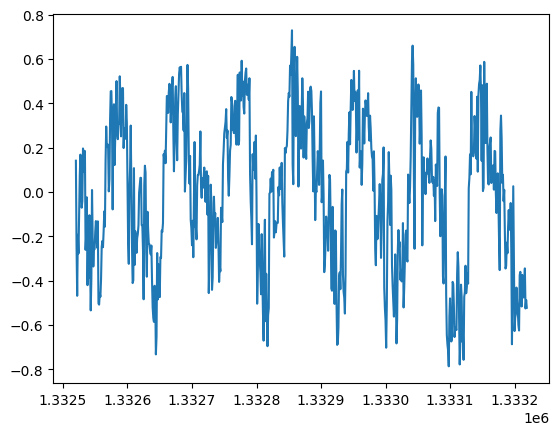

In [24]:
mum = 70
i = 50
for id, df in df_m.groupby('node_id'):
    i += 1
    df.sort_values('date_time', inplace=True)
    df1 = df
    if i == mum:
        break
df1
df1.voltage[1000:1700].plot()

In [25]:
loss1, loss2 = ([16372.762358825654, 16634.703364126384, 16543.08532262966, 16131.479897167534, 16169.90375995636, 16022.7727599293, 16028.855142690241, 16073.159623518586, 16015.877715405077, 16092.323755457997, 16045.38031392172, 16087.149139348418, 15985.105048321187, 15989.13289052248, 15987.644243543968, 16037.899947874248, 15977.035003256053, 15968.611596148461, 15902.993992701173, 15923.164500877261, 15990.52543747425, 15967.374350298196, 16112.471801526845, 15867.862705204636, 16044.10736612603, 16108.341628603637, 15983.205983111635, 15863.019351959229, 16091.737399615347, 15948.399221111089, 16030.345640648156, 15988.57823552005, 15596.308297041804, 16010.228194277734, 15933.166574150324, 15904.26735413447, 15961.08911305666, 15897.487737651914, 16100.742928672582, 15729.526669826359, 15995.381566096097, 15949.067400943488, 15914.28550195694, 16052.250756880268, 16283.16515108943, 16016.96263905242, 16112.13678047061, 15196.600606389344, 16107.529791213572, 15796.224195510149, 16071.419707216322, 15935.938538838178, 15985.38385669887, 15998.576839532703, 16408.408283419907, 16014.249487113208, 16050.331765610725, 16021.419686503708, 16052.864892493933, 15984.254602197558, 15316.28803390637, 15967.03768985346, 16217.060092099011, 16396.4722488001, 16159.847911708057, 16030.863571196795, 16083.443666517735, 16159.115450445563, 16092.994627105072, 15941.518173033372, 16280.668275836855, 15684.87470657751, 15772.554526805878, 16193.99966667965, 15201.68643815443, 15545.335323885083, 16106.075196858495, 16068.103003468364, 16045.174951121211, 16204.489080738276, 16161.652160331607, 15981.514236524701, 15993.769934050739, 15952.472354874015, 16123.18293023482, 15734.633713591844, 15866.234449129552, 16078.250679172575, 16012.676165167242, 15852.570465866476, 16026.388614390045, 15902.594948275015, 16034.230974230915, 15984.706976942718, 16036.916211958975, 16118.060617826879, 16134.900142215192, 16062.636342648417, 15979.18484370038, 16030.161203432828], [5785.595439456403, 5427.625621035695, 4514.663075968623, 4776.318674221635, 4261.33434882015, 4178.248902689666, 4368.469807688147, 4779.973441749811, 4577.602933254093, 4778.648789960891, 4407.309711184353, 4368.018818285316, 4388.349081538618, 4446.118443965912, 4255.978350132704, 4531.136258535087, 4065.724209792912, 4113.981672920287, 4053.120807670057, 4074.1358869075775, 3930.117473896593, 3878.142276789993, 3991.378495682031, 4116.873412977904, 4087.7675153054297, 4170.202090229839, 4126.709680955857, 4285.420569904149, 4075.271260879934, 3976.6686209477484, 4085.4610562063754, 4017.2228969857097, 3980.7382762245834, 4326.4731184616685, 4132.755304209888, 4210.008221834898, 4220.57588365674, 4003.8390374593437, 3962.551026172936, 4553.417801707983, 4271.924326386303, 4868.862559959292, 4813.444682650268, 4283.133677363396, 4344.488324947655, 4140.852845706046, 4015.650432795286, 4233.296441063285, 4301.128348834813, 4316.6798555627465, 5035.599082767963, 4234.5857656523585, 3922.4163610190153, 4000.6682582460344, 3939.538450639695, 3936.4654266014695, 3954.0273206159472, 4045.763175856322, 4190.162593506277, 4190.855183668435, 4841.06457401067, 4073.3767104558647, 4167.886702634394, 4404.28796678409, 4257.710883900523, 4159.200102776289, 4081.588713556528, 3829.1924005821347, 3940.9274297207594, 4268.539490699768, 4343.295275982469, 4028.4511752277613, 4107.140547297895, 4099.667154880241, 3772.177902814001, 4011.15374526754, 4125.960661917925, 4224.2361962124705, 4459.421056523919, 4188.387106183916, 4206.991083428264, 4236.832082800567, 4118.728419672698, 4155.7071578502655, 4288.350934196264, 4246.946950443089, 4221.465052351356, 4225.457578524947, 4224.181969620287, 4125.748569764197, 4236.596596248448, 4318.576657116413, 4345.944565951824, 4097.978936612606, 4183.67160179466, 4203.090598437935, 4223.967044785619, 4148.796589612961, 4207.551894135773, 4152.825014844537])

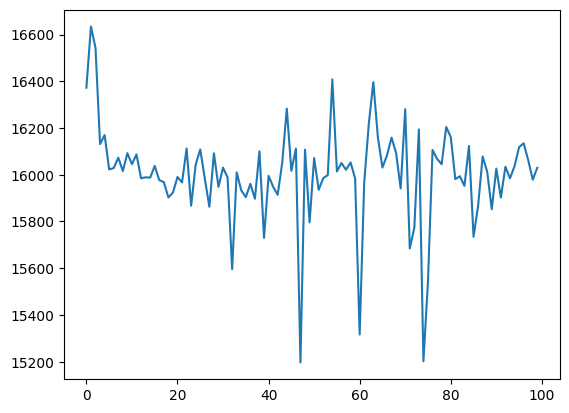

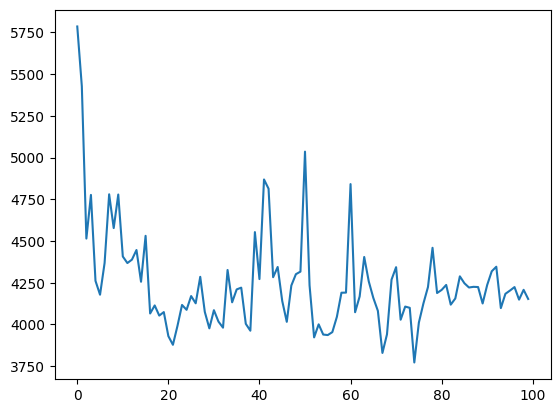

In [26]:
import matplotlib.pyplot as plt
plt.plot(loss1)
plt.show()
plt.plot(loss2)
plt.show()

In [27]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../src/utils")
from utils import SimpleGraphVoltDatasetLoader_Lazy
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

def train_test(model, device, loader, train_dataset, test_dataset, optimizer, loss_fn, epochs, now, hidden=32, name=None, scheduler=None):
    """
    Definition of the training loop.
    """
    if name is None:
        raise ValueError("name must not be None")
    epoch_losses_train = []
    epoch_losses_test = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss_train = 0
        for snapshot_i in tqdm(train_dataset, desc="Training epoch {}".format(epoch)):
            snapshot = loader.get_snapshot(snapshot_i)
            snapshot.to(device)
            optimizer.zero_grad()
            out = model(snapshot.x, snapshot.edge_index)
            loss = loss_fn()(out, snapshot.y)
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.detach().cpu().numpy()
        if scheduler is not None:
            scheduler.step(epoch_loss_train)
        epoch_losses_train.append(epoch_loss_train)
        model.eval()
        epoch_loss_test = 0
        with torch.no_grad():
            for snapshot_j in tqdm(test_dataset, desc="Testing epoch {}".format(epoch)):
                snapshot = loader.get_snapshot(snapshot_j)
                snapshot.to(device)
                out = model(snapshot.x, snapshot.edge_index)
                loss = loss_fn()(out, snapshot.y).cpu().numpy()
                epoch_loss_test += loss
            epoch_losses_test.append(epoch_loss_test)
            # if min(epoch_losses_test) == epoch_loss_test:
            #     torch.save(model.state_dict(), name)
            print("Epoch: {}, Train Loss: {:.7f}, Test Loss: {:.7f}".format(epoch, epoch_loss_train, epoch_loss_test))
        
        
    return epoch_losses_train, epoch_losses_test
            
def eval(model, loader, eval_dataset, device, loss_fn, std):
    with torch.no_grad():
        model.eval()
        loss_all = 0
        loss_elementwise = 0
        
        steps = 0
        for snapshot_i in tqdm(eval_dataset, desc="Evaluating"):
            snapshot = loader.get_snapshot(snapshot_i)
            steps += 1
            snapshot.to(device)
            out = model(snapshot.x, snapshot.edge_index)
            loss_all += loss_fn()(out, snapshot.y).cpu().numpy()
            loss_elementwise += loss_fn(reduction="none")(out, snapshot.y).cpu().numpy()
        loss_all *= std/steps
        loss_elementwise *= std/steps
    return loss_all, loss_elementwise
#------parameters------ 

trafo_id = "T1330"
epochs = 30
num_timesteps_in = 12
num_timesteps_out = 4
train_ratio = 0.7
test_ratio_vs_eval_ratio = 0.5
learning_rate = 0.01
device_str = 'cpu'
hidden = 32

#----------------------
if device_str == 'cuda':
    torch.cuda.empty_cache()

#get dateime string of now
now = pd.Timestamp.now().strftime("%Y%m%d%H%M%S")

name = f"../models/A3TGCN_{now}_{trafo_id}_epochs-{epochs}_in-{num_timesteps_in}_out-{num_timesteps_out}_train-ratio-{train_ratio}_lr-{learning_rate}_hidden-{hidden}.pt"

print("Loading data...")
loader = SimpleGraphVoltDatasetLoader_Lazy(trafo_id, num_timesteps_in, num_timesteps_out)
print(" done")
loader_data_index = loader.snapshot_index

train_dataset, test_eval_dataset = loader.temporal_signal_split_lazy(loader_data_index, train_ratio=train_ratio)
test_dataset, eval_dataset = loader.temporal_signal_split_lazy(test_eval_dataset, train_ratio=test_ratio_vs_eval_ratio)




Loading data...
c:\Users\tomot\OneDrive\Namizje\mlg\Project\GraphVolt
c:\Users\tomot\OneDrive\Namizje\mlg\Project\GraphVolt\data\networks_data_raw
Voltage index: 5
 done


In [28]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods, hidden=32):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        out_channels = hidden
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=out_channels, 
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(out_channels, periods)

    def forward(self, x, edge_index, edge_weight):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        print(edge_weight.shape)
        h = F.relu(h)
        h = self.linear(h)
        raise ValueError("h.shape: {}".format(h.shape))
        return h
    

In [29]:
def train_test(model,device, train_dataset, test_dataset, optimizer, loss_fn, epochs, now):
    """
    Definition of the training loop.
    """
    epoch_losses_train = []
    epoch_losses_test = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss_train = 0

        subset = 3
        step=0

        for snapshot in tqdm(train_dataset, desc="Training epoch {}".format(epoch)):
            snapshot.to(device)

            optimizer.zero_grad()
            out = model(snapshot.x, snapshot.edge_index,snapshot.edge_weight)
            loss = loss_fn()(out, snapshot.y)
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.detach().cpu().numpy()

            step+=1

            if step > subset:
                break


        epoch_losses_train.append(epoch_loss_train)

        print(f"Epoch {epoch + 1}, FeatureMLP Weights: {model.state_dict()['feature_mlp.weight']}")

        model.eval()
        epoch_loss_test = 0
        with torch.no_grad():

            subset = 100
            step=0

            for snapshot in tqdm(test_dataset, desc="Testing epoch {}".format(epoch)):
                snapshot.to(device)

                out = model(snapshot.x, snapshot.edge_index,snapshot.edge_weight)
                loss = loss_fn()(out, snapshot.y).cpu().numpy()
                epoch_loss_test += loss

                step+=1
                if step > subset:
                    break

            epoch_losses_test.append(epoch_loss_test)
            if min(epoch_losses_test) == epoch_loss_test:
                torch.save(model.state_dict(), f"../models/A3TGCN_{now}_{trafo_id}_epochs-{epochs}_in-{num_timesteps_in}_out-{num_timesteps_out}_train-ratio-{train_ratio}_lr-{learning_rate}.pt")
            print("Epoch: {}, Train Loss: {:.7f}, Test Loss: {:.7f}".format(epoch, epoch_loss_train, epoch_loss_test))
        
        
    return epoch_losses_train, epoch_losses_test
            

In [30]:
print("Running training...")
# num_of_nodes = train_dataset[0].x.shape[0]
num_of_features = loader.num_features
# num_of_timesteps = train_dataset[0].x.shape[2]

device = torch.device(device_str)
#feature_mlp = FeatureMLP(num_of_nodes,num_of_features,num_timesteps_in).to(device)
model = TemporalGNN(node_features=num_of_features, periods=train_dataset[0].y.shape[1],num_timesteps_in=num_timesteps_in,num_of_nodes=num_of_nodes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.L1Loss
losses = train_test(model, device, train_dataset, test_dataset, optimizer, loss_fn, epochs=epochs, now=now)

Running training...


AttributeError: 'int' object has no attribute 'y'

In [ ]:
print("Running training...")
device = torch.device(device_str)
model = TemporalGNN(node_features=loader.num_features, periods=num_timesteps_out, hidden=hidden).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.L1Loss
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
losses = train_test(model, device, loader, train_dataset, test_dataset, optimizer, loss_fn, epochs=epochs, now=now, hidden=hidden, name=name, scheduler=scheduler)


Running training...


Training epoch 0:   0%|          | 0/49045 [00:00<?, ?it/s]

Training epoch 0:   0%|          | 0/49045 [00:00<?, ?it/s]

torch.Size([2, 114])


ValueError: h.shape: torch.Size([113, 4])